<a href="https://colab.research.google.com/github/Research-method-group-3/Spaceship-Titanic/blob/dev-ayoola/Group_3_spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  An End to End Machine learning project using the Spaceship titanic Dataset

## Introduction

In this project we will be developing an end to end machine learning pipeline Using the spaceship titanic dataset. The Spaceship titanic is a very popular dataset in the data science community. The particular dataset used in this development was gotten from kaggle. The dataset contains details of passsengers on a spaceship heading to Destinations outside our solar system. \

However, just like the RMS Titanic encouter a tragedy when it collides with an iceberg on its voyage and never made to New York, the Spaceship Titanic also collided with a spacetime anomaly which results in the Transportation of some passengers to an alternate dimension. \

The Spaceship titanic dataset contains the records of passengers on board and also include details on whether they were transported or not. There are two dataset in the spaceship data directory namely train and test. The train dataset contains details on whether the passenger was transported whereby the target column transported is absent in the test dataset. \

Before a model can be trained to predict the traget columns of the test dataset some number of task as to be performed on the dataset to gain more insight about the data i.e finding parterns between the two classes, cleaning the data and finding the optimal way of getting the missing values in the dataset.





In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.colors as colors
from tensorflow.keras import models, Sequential, layers, Model, metrics
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, concatenate
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
TRAIN_PATH = '/content/drive/MyDrive/Spaceship-titanic/train.csv'
TEST_PATH = '/content/drive/MyDrive/Spaceship-titanic/test.csv'
TARGET_CLASS = 'Transported'

## Data Description

In [22]:
#load training data from csv
df = pd.read_csv(TRAIN_PATH)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [23]:
# function to plot line plot
def lineplot(df, model_name):
  # Create a figure
  fig = go.Figure()

  # Add trace for line plot with column 'y1'
  for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[str(col)], mode='lines', name=str(col)))

  fig.update_layout(title=f'Training and validation result for {model_name}',
                    xaxis_title='Epochs',
                    yaxis_title='Metrics and losses',
                    width=800,
                    height=600,
                    plot_bgcolor='#000000',
                    paper_bgcolor='#000000',
                    font=dict(color="white" ))



  # Show the graph
  fig.show()

In [24]:
# function for missing value
def missing_values(df):
  missing_values = df.isna().sum().to_frame()
  missing_values = missing_values.rename(columns={0: 'missing_values'})
  missing_values['% of total'] = (missing_values['missing_values'] / df.shape[0]).round(2)*100
  print(missing_values)


  fig = px.bar(x=missing_values.index,
               y='missing_values',
               data_frame=missing_values,
               #color=palette
               )

  fig.update_layout(width=800,
                    height=600,
                    title='Missing values',
                    xaxis_title = 'columns',
                    yaxis_title='number of missing values in each column',
                    plot_bgcolor='#000000',
                    paper_bgcolor='#000000',
                    font=dict(color="white" )
                    )


  fig.show()

In [25]:
#check missing values
missing_values(df)

              missing_values  % of total
PassengerId                0         0.0
HomePlanet               201         2.0
CryoSleep                217         2.0
Cabin                    199         2.0
Destination              182         2.0
Age                      179         2.0
VIP                      203         2.0
RoomService              181         2.0
FoodCourt                183         2.0
ShoppingMall             208         2.0
Spa                      183         2.0
VRDeck                   188         2.0
Name                     200         2.0
Transported                0         0.0


From a brief preview of the dataset we are able to get some understanding about the dataset from the total number of columns present in the dataset and the numbers of missing values.

The bar graph above visualize the number of missing values in each column. Where columns with missing values all have about 179 to 217 missing values. The passengerId and transported columns are the only columns without any mising value. \

The missing value dataframe from above also specify the percentage of missing value in each column which are all approximately 2 percentage.

Before anything can be done to the missing values in each columns we need to have some domain knowledge about each columns and their relationship to other columns this will enable us find an optimal and effective solution to solving the missing value problem.

### Column Description

 | Columns        | Dtype | Description |
|-----------------|-----------------|-----------------|
| PassengerID     | Object          | Unique identifier for each passenger    |
| HomePlanet      | Object          | The planet the passengers departed from    |
| CryoSleep      | object           |   Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. |
| Cabin | object | The cabin number where the passenger is staying. Takes the form deck/num/side |
| Destination | Object | The planet the passenger will be debarking to |
| Age | float64| The age of the passenger |
| ViP | Object | Whether the passenger has paid for special VIP service during the voyage.
|RoomService|float64 | Amount the passenger has billed|
|FoodCourt| float64|Amount the passenger has billed |
|ShoppingMall| float64|Amount the passenger has billed |
| Spa|float64 |Amount the passenger has billed |
|VRDeck| float63| Amount the passenger has billed|
| Name |  Object | The first and last names of the passenger. |
|Transported | bool | Whether the passenger was transported to another dimension. This is the target.|

### Column constraint
- Passengers in Cryosleep can't have any incured bills. Therefore, columns RoomService, FoodCourt, ShoppingMall, Spa, VRDeck should be zero if cryosleep is true
- Passengers in Cryosleep cant be VIP. It isn't logical for a passenger in cryosleep to pay for VIP services

Since we've establish this set of constraint we can go ahead and input missing values before further exploratory data analysis. the missing values are fill in by replacing nan values in columns with object dtypes with the mode of the column and column with float64 dtypes with the mean of the column.

Once This is done the next task is to implement the constraint in the dataset and transform the columns with object dtype to a more suitable dtype for machine learning and plotting. The column cabin which is in the form Deck/cabin_num/side also need to be split into 3 to enable further analysis.



In [26]:
# fill in missing data
for col in df.columns:
    if df[str(col)].dtypes == 'object':
      df[str(col)].fillna(df[str(col)].mode()[0], inplace=True)
    elif df[str(col)].dtypes == 'float64':
      df[str(col)].fillna(df[str(col)].mean().round(0), inplace=True)

# implement constraint for cryosleep , vip, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
df['Cabin_num'] = df['Cabin_num'].astype(int)
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].astype(int)

#passenger in cryosleep can't buy anything
df.loc[df['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0

#passengers in cryosleep can't be vip
df.loc[df['CryoSleep'] == True, ['VIP']] = False
bool_column = df.select_dtypes(include='bool').columns

df[bool_column] = df[bool_column].astype(bool)

#drop cabin
df_clean = df.drop(columns=['Cabin'], axis=1)
df_clean.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0,0,0,0,0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109,9,25,549,44,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43,3576,0,6715,49,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0,1283,371,3329,193,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303,70,151,565,2,Willy Santantines,True,F,1,S


In [27]:
#check dataframe again for missing value with missing value function
missing_values(df)

              missing_values  % of total
PassengerId                0         0.0
HomePlanet                 0         0.0
CryoSleep                  0         0.0
Cabin                      0         0.0
Destination                0         0.0
Age                        0         0.0
VIP                        0         0.0
RoomService                0         0.0
FoodCourt                  0         0.0
ShoppingMall               0         0.0
Spa                        0         0.0
VRDeck                     0         0.0
Name                       0         0.0
Transported                0         0.0
Deck                       0         0.0
Cabin_num                  0         0.0
Side                       0         0.0


## Exploratory Data Analysis

The percentage of passengers that were transported and not transported on the space ship is very close this can be observed in the pie chart below. Therefore, the case of class imbalance where one class is significantly larger than the other doesn’t exist in this case and no action is needed to be taken to correct this during training.

In [28]:
# create class transported dictionary from the transported column
class_transported = df_clean['Transported'].value_counts().to_dict()

palette = px.colors.sequential.Cividis

# Extract keys and values
labels = list(class_transported.keys())
values = list(class_transported.values())

# Create pie chart
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,
                             hole=0.4,
                             marker=dict(colors=palette)
                             )]
)

# Adjust font and text properties
fig.update_traces(textposition='outside', textinfo='percent+label',
                  marker=dict(line=dict(color='#000000', width=1)))

# Adjust layout
fig.update_layout(
    title='Pie Chart of Transported class',
    title_font=dict(size=24, family='Arial'),
    legend=dict(
        title='Transported',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5
    ),
    plot_bgcolor='#000000',
    paper_bgcolor='#000000',
    font=dict(color="white" )
)

fig.show()

In [29]:
#plot for age distribution across the spaceship
fig = px.histogram(df_clean, x='Age')

fig.update_layout(width=800,
                  height=600,
                  title='Age distribution across the ship',
                  xaxis_title = 'columns',
                  yaxis_title='Distribution of Age',
                  plot_bgcolor='#000000',
                  paper_bgcolor='#000000',
                  font=dict(color="white" )
                  )
fig.show()

In [30]:
# aggregate data to count passengers on each deck, side, and other categorical column
df_group = df_clean.groupby(['Transported', 'Deck', 'Side', 'VIP', 'CryoSleep', 'HomePlanet', 'Destination']).agg(passenger_count=('Name', 'count'),
                                                      spa_mean=('Spa', 'mean'),
                                                      room_service_mean=('RoomService', 'mean'),
                                                      food_court_mean=('FoodCourt', 'mean'),
                                                      shopping_mall_mean=('ShoppingMall', 'mean'),
                                                      vr_deck_mean=('VRDeck', 'mean')
                                                      ).reset_index()

df_group.head()

,Transported,Deck,Side,VIP,CryoSleep,HomePlanet,Destination,passenger_count,spa_mean,room_service_mean,food_court_mean,shopping_mall_mean,vr_deck_mean
0,False,A,P,False,False,Earth,55 Cancri e,1,11001.000000,0.000000,2506.000000,46.0,5.000000
1,False,A,P,False,False,Earth,TRAPPIST-1e,1,65.000000,0.000000,2344.000000,0.0,6898.000000
2,False,A,P,False,False,Europa,55 Cancri e,20,1096.200000,100.050000,1576.900000,135.5,1468.550000
3,False,A,P,False,False,Europa,TRAPPIST-1e,30,1405.566667,443.933333,1009.433333,240.5,1805.466667
4,False,A,P,False,True,Europa,55 Cancri e,1,0.000000,0.000000,0.000000,0.0,0.000000


From the below plot it can be observed that there more passengers on the port side of the spaceship compared to the starboard side. This can be as result of the higher number of passengers in cryosleep also on the port side of the spaceship which can be observed in the Transported class Deck and cryosleep plot. A possible explanation for that is because a cabin can hold more passengers in cryosleep.

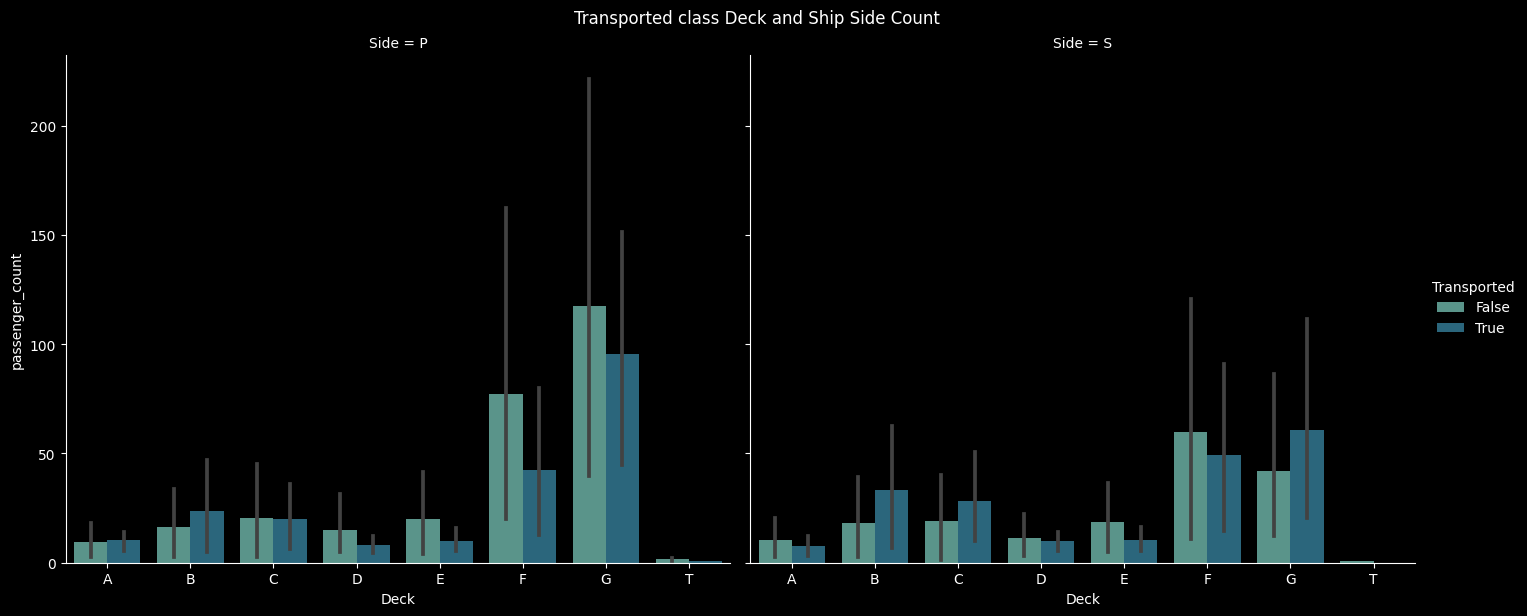

In [31]:
# Create a grouped bar plot
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='passenger_count',
    hue='Transported',
    col='Side',
    data=df_group,
    kind='bar',
    height=6,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Transported class Deck and Ship Side Count', y=1.02)

# Show the plot
plt.show()


<Figure size 1000x1000 with 0 Axes>

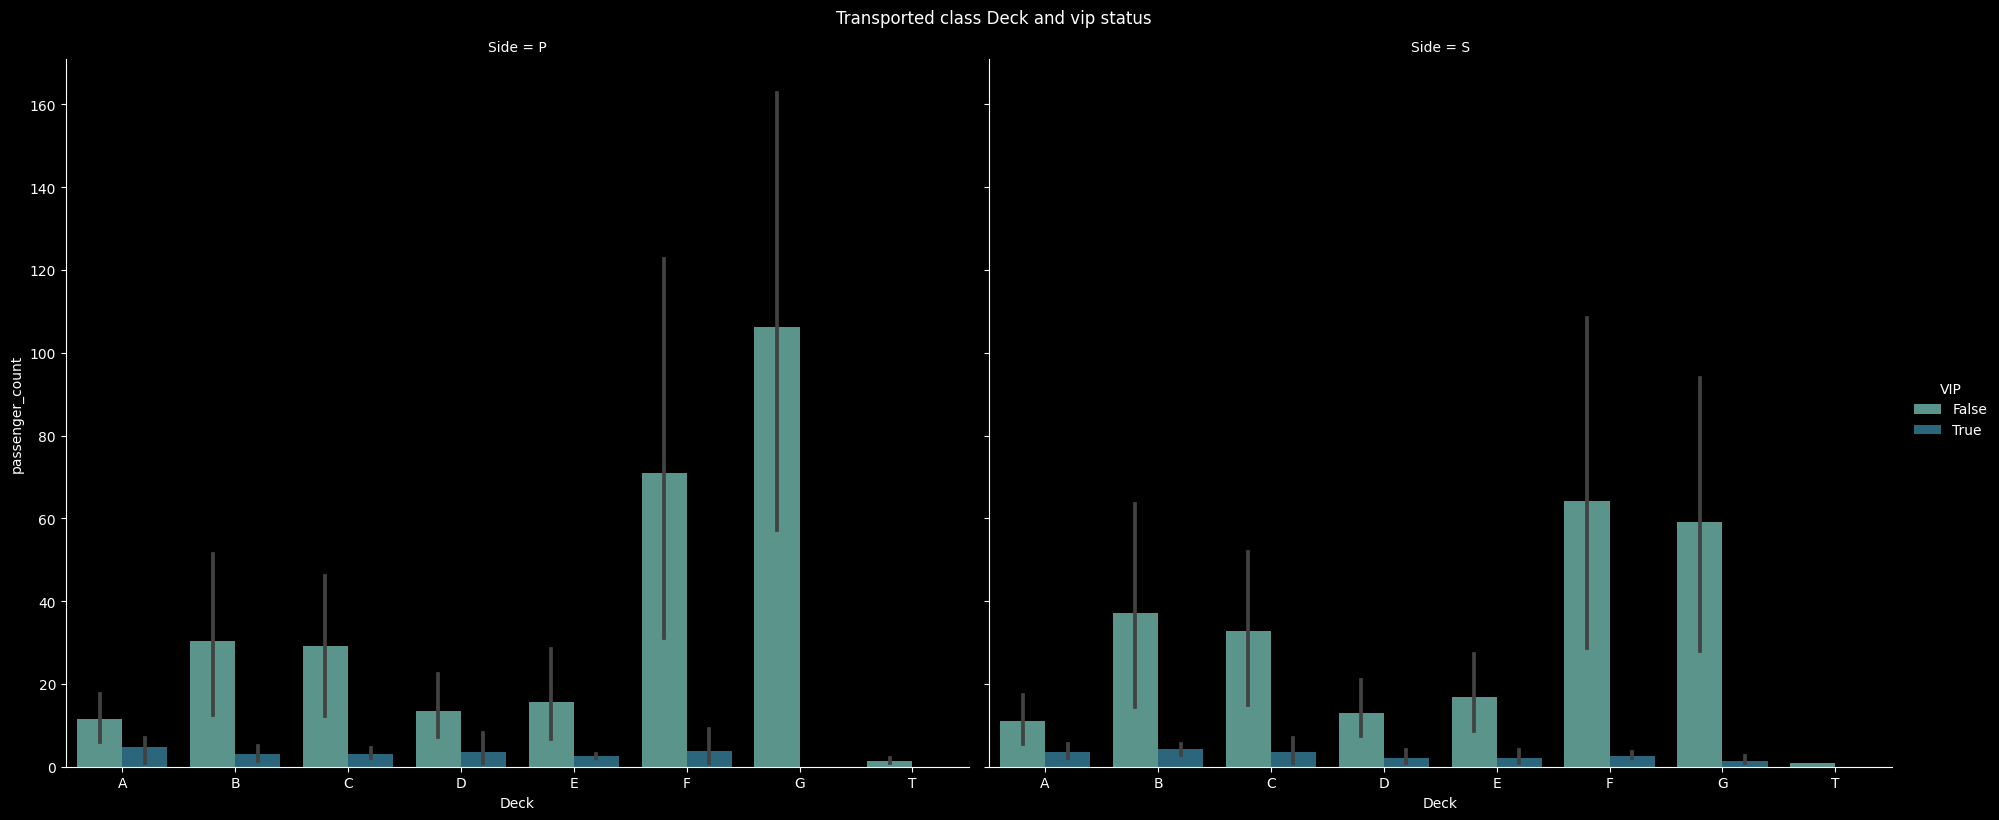

In [32]:
# Plot number of transported passengers and vip status on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='passenger_count',
    hue='VIP',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Transported class Deck and vip status', y=1.02)

# Show the plot
plt.show()


<Figure size 1000x1000 with 0 Axes>

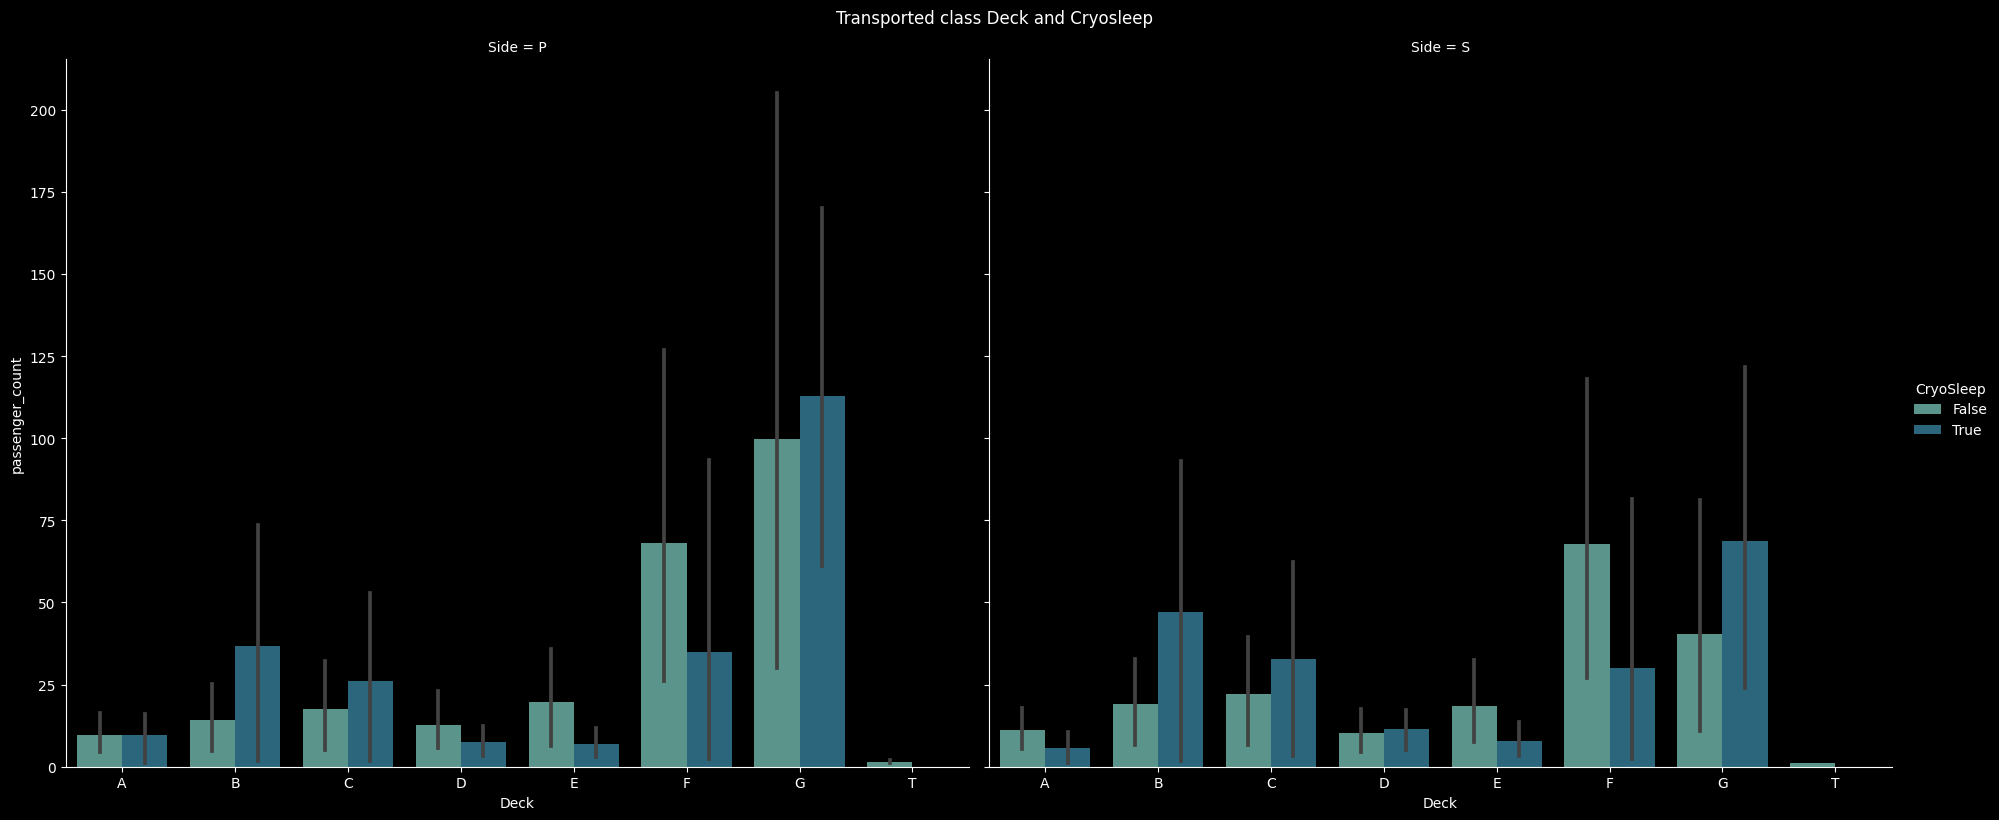

In [33]:
# Plot number of transported passengers homeplanet on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='passenger_count',
    hue='CryoSleep',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Transported class Deck and Cryosleep', y=1.02)

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

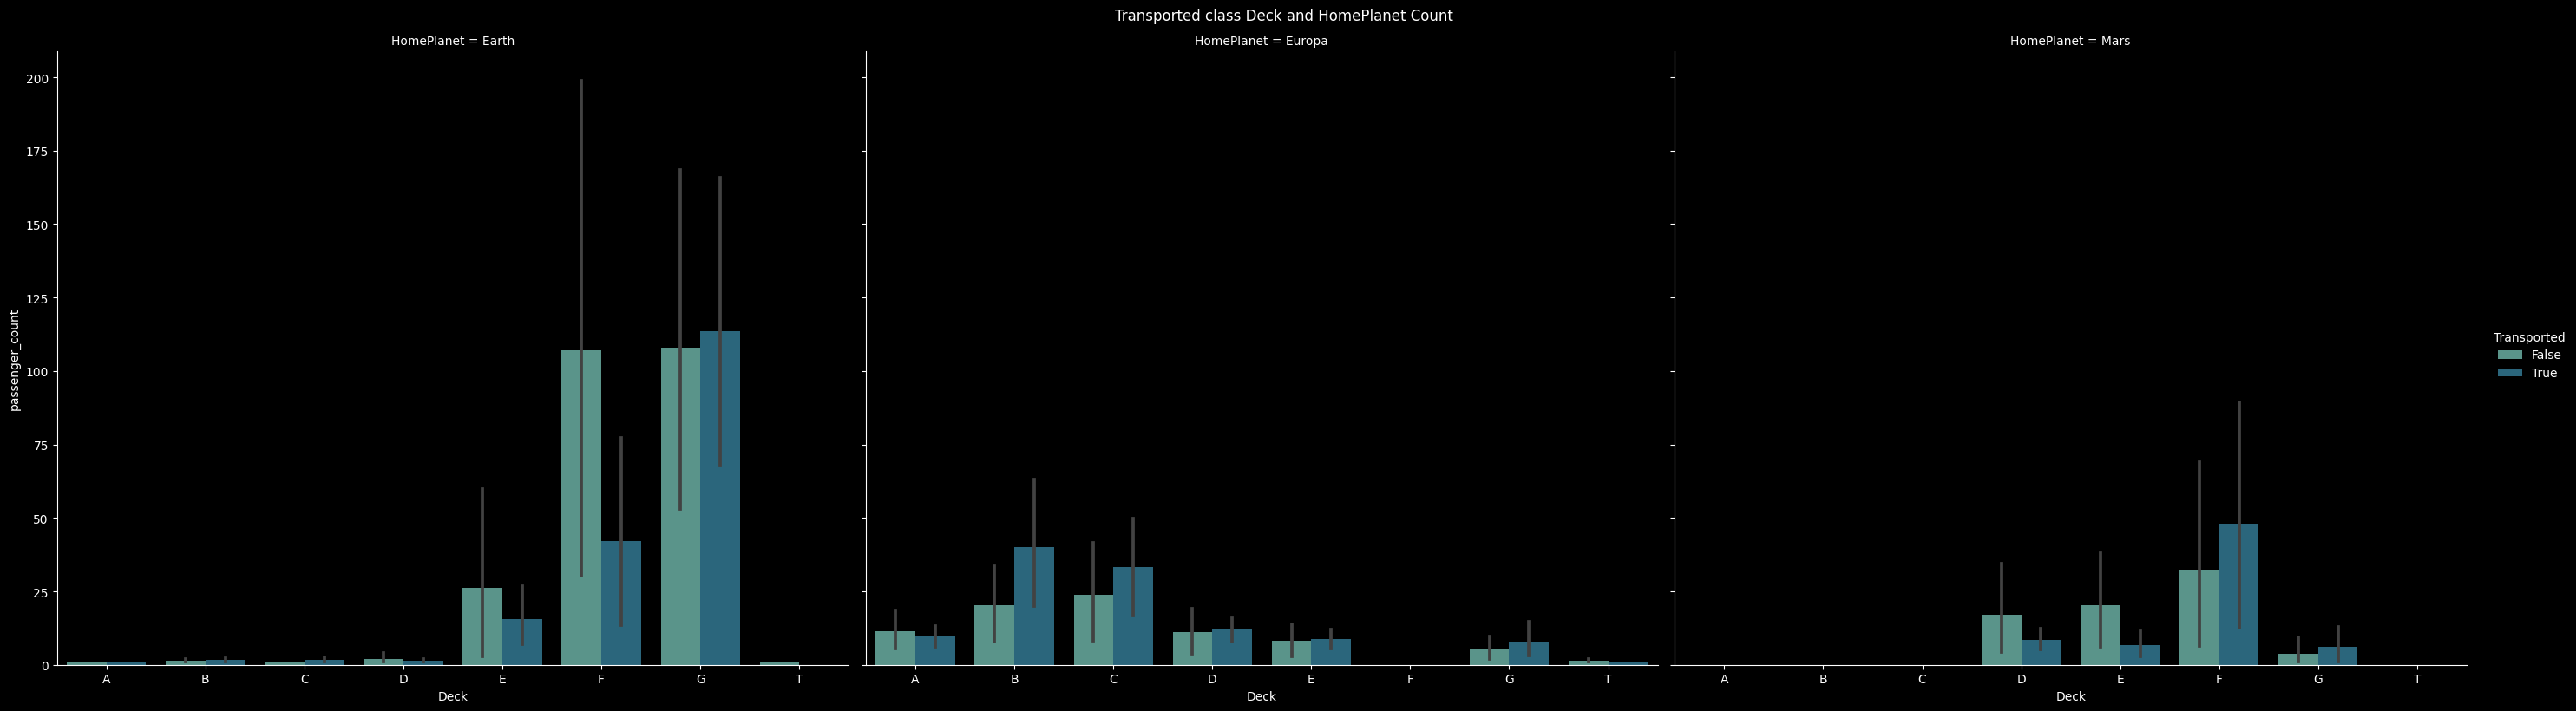

In [34]:
# Plot number of transported passengers homeplanet on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='passenger_count',
    hue='Transported',
    col='HomePlanet',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Transported class Deck and HomePlanet Count', y=1.02)

# Show the plot
plt.show()


<Figure size 1000x1000 with 0 Axes>

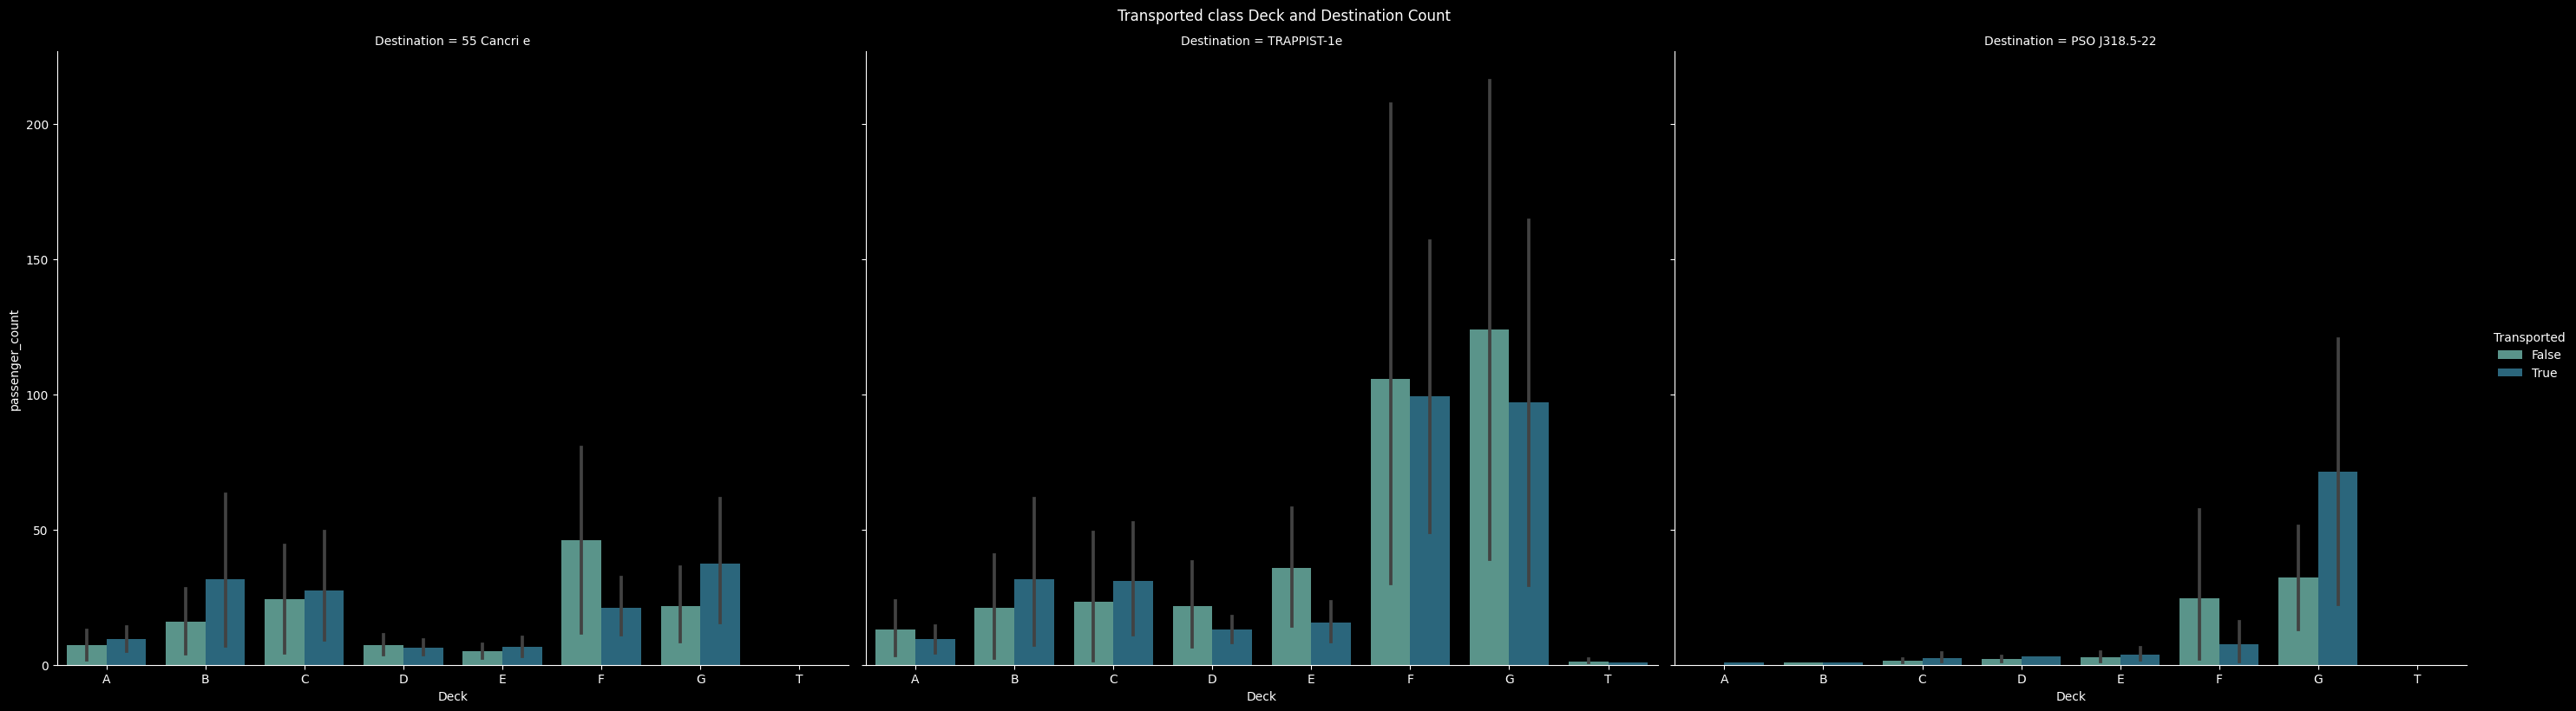

In [35]:
# Plot number of transported passengers Destination on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='passenger_count',
    hue='Transported',
    col='Destination',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Transported class Deck and Destination Count', y=1.02)

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

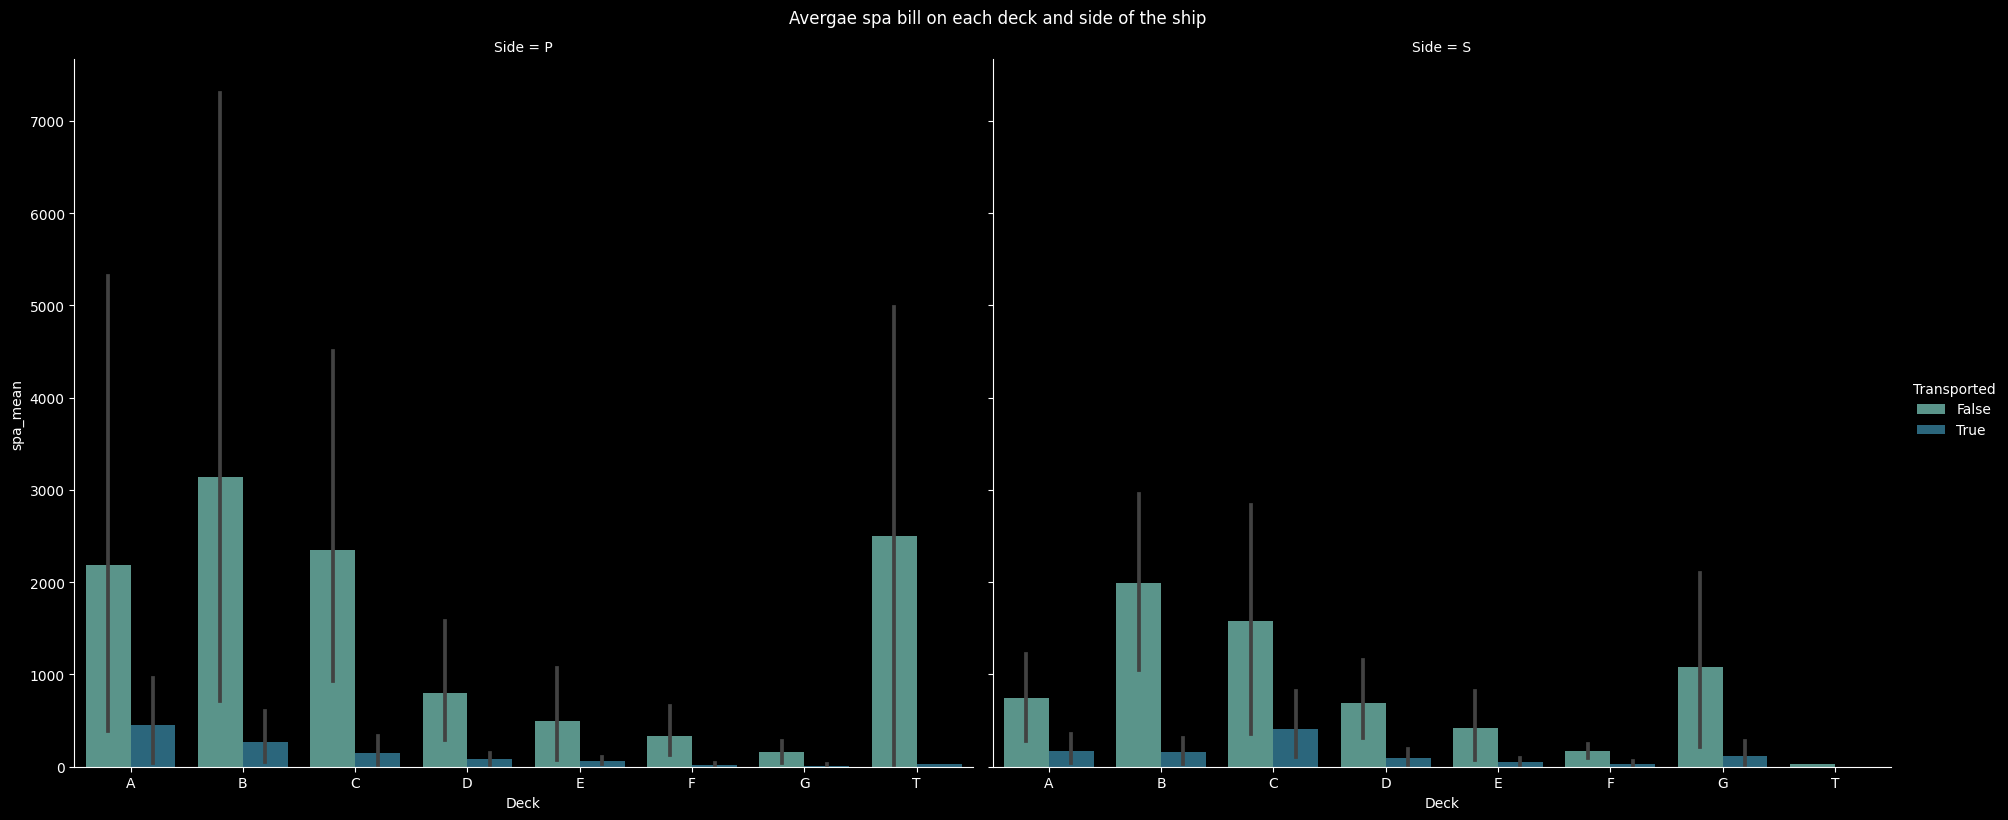

In [36]:
# Plot number of transported passengers and their spa bill on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='spa_mean',
    hue='Transported',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Avergae spa bill on each deck and side of the ship', y=1.02)

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

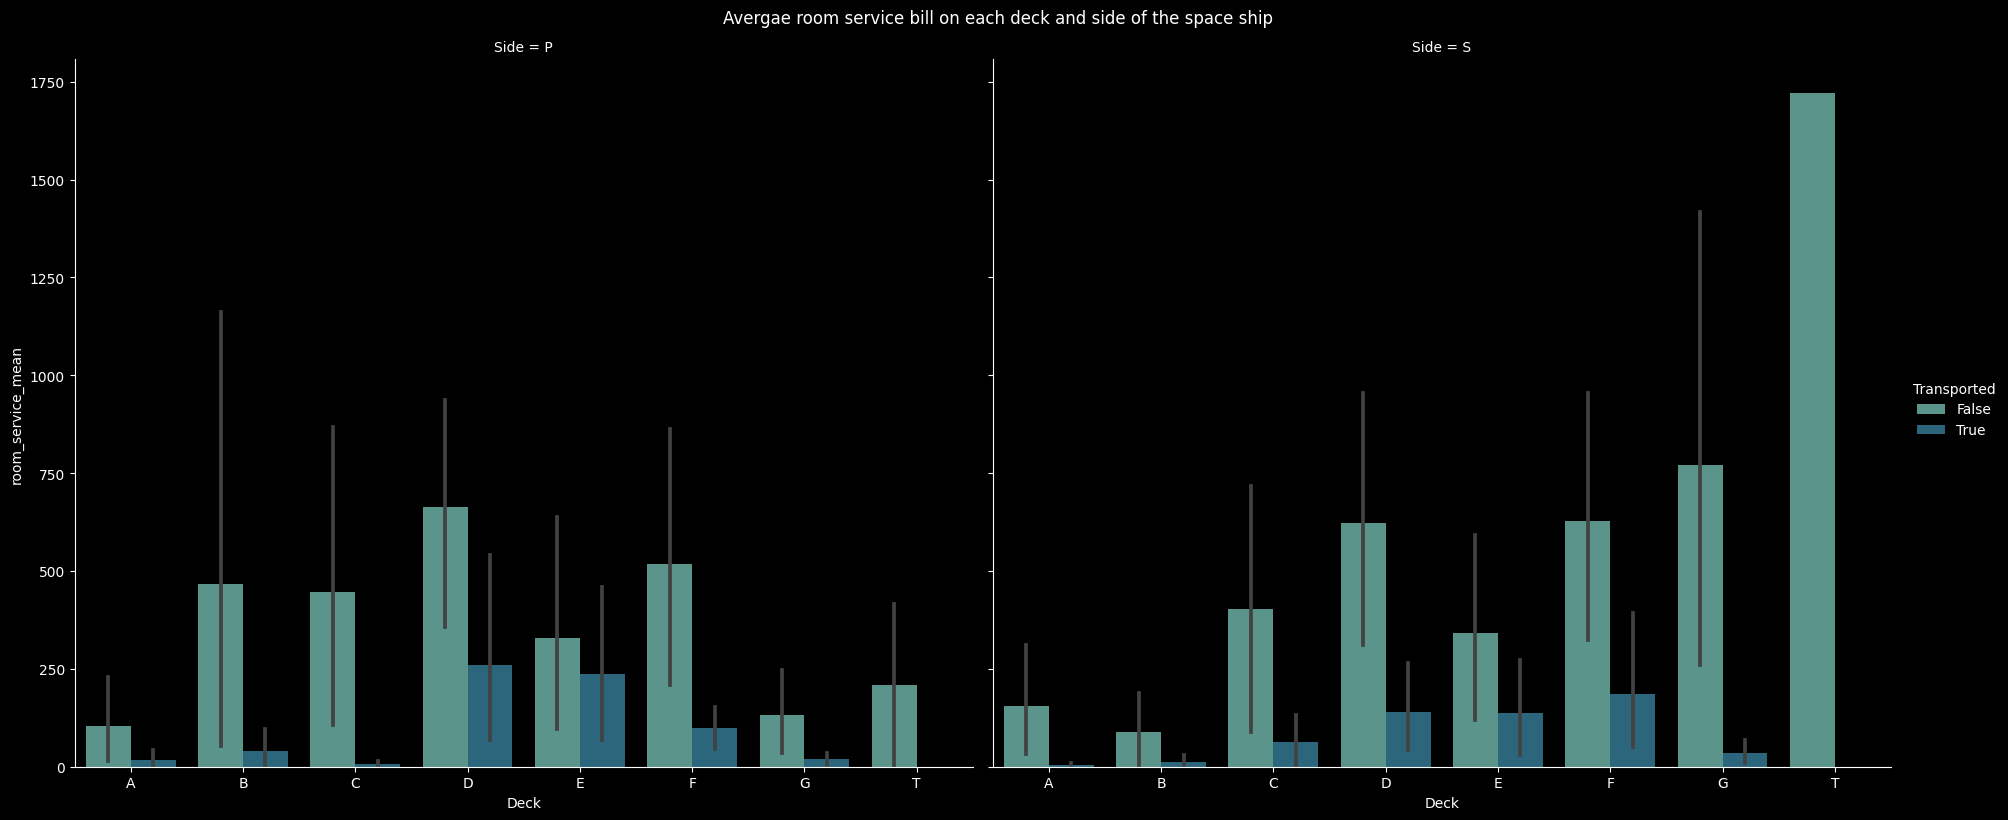

In [37]:
# Plot number of transported passengers and avergae room servce on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='room_service_mean',
    hue='Transported',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Avergae room service bill on each deck and side of the space ship', y=1.02)

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

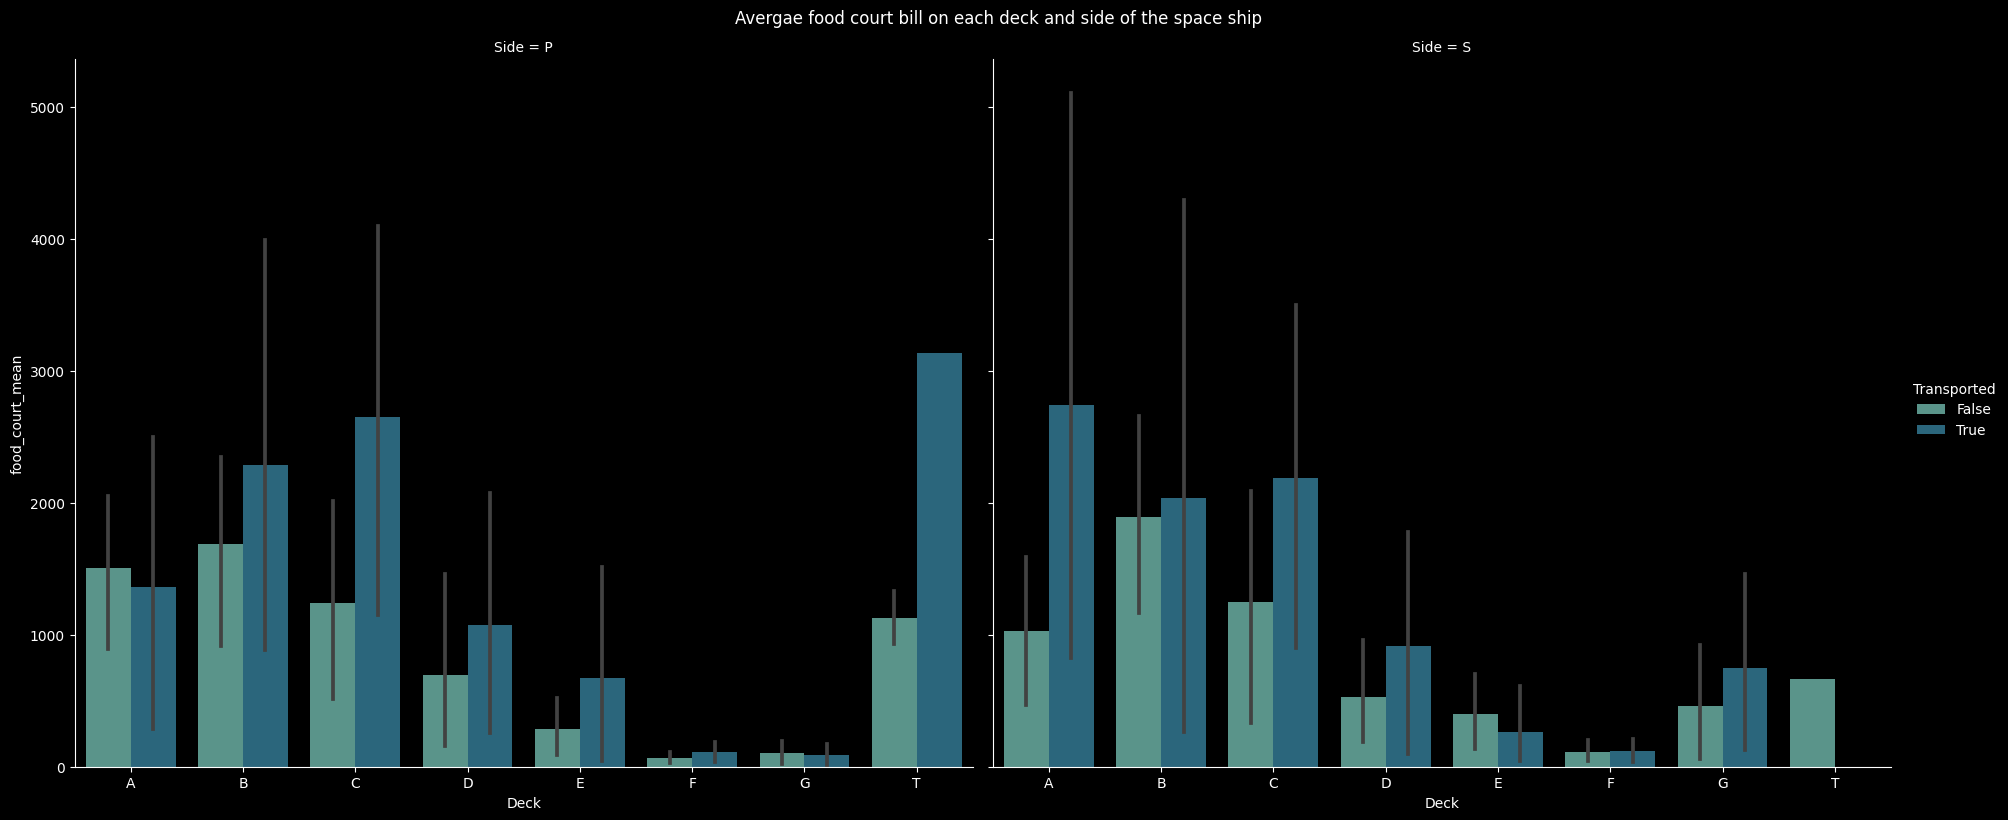

In [38]:
# Plot number of transported passengers and avergae room servce on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='food_court_mean',
    hue='Transported',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Avergae food court bill on each deck and side of the space ship', y=1.02)

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

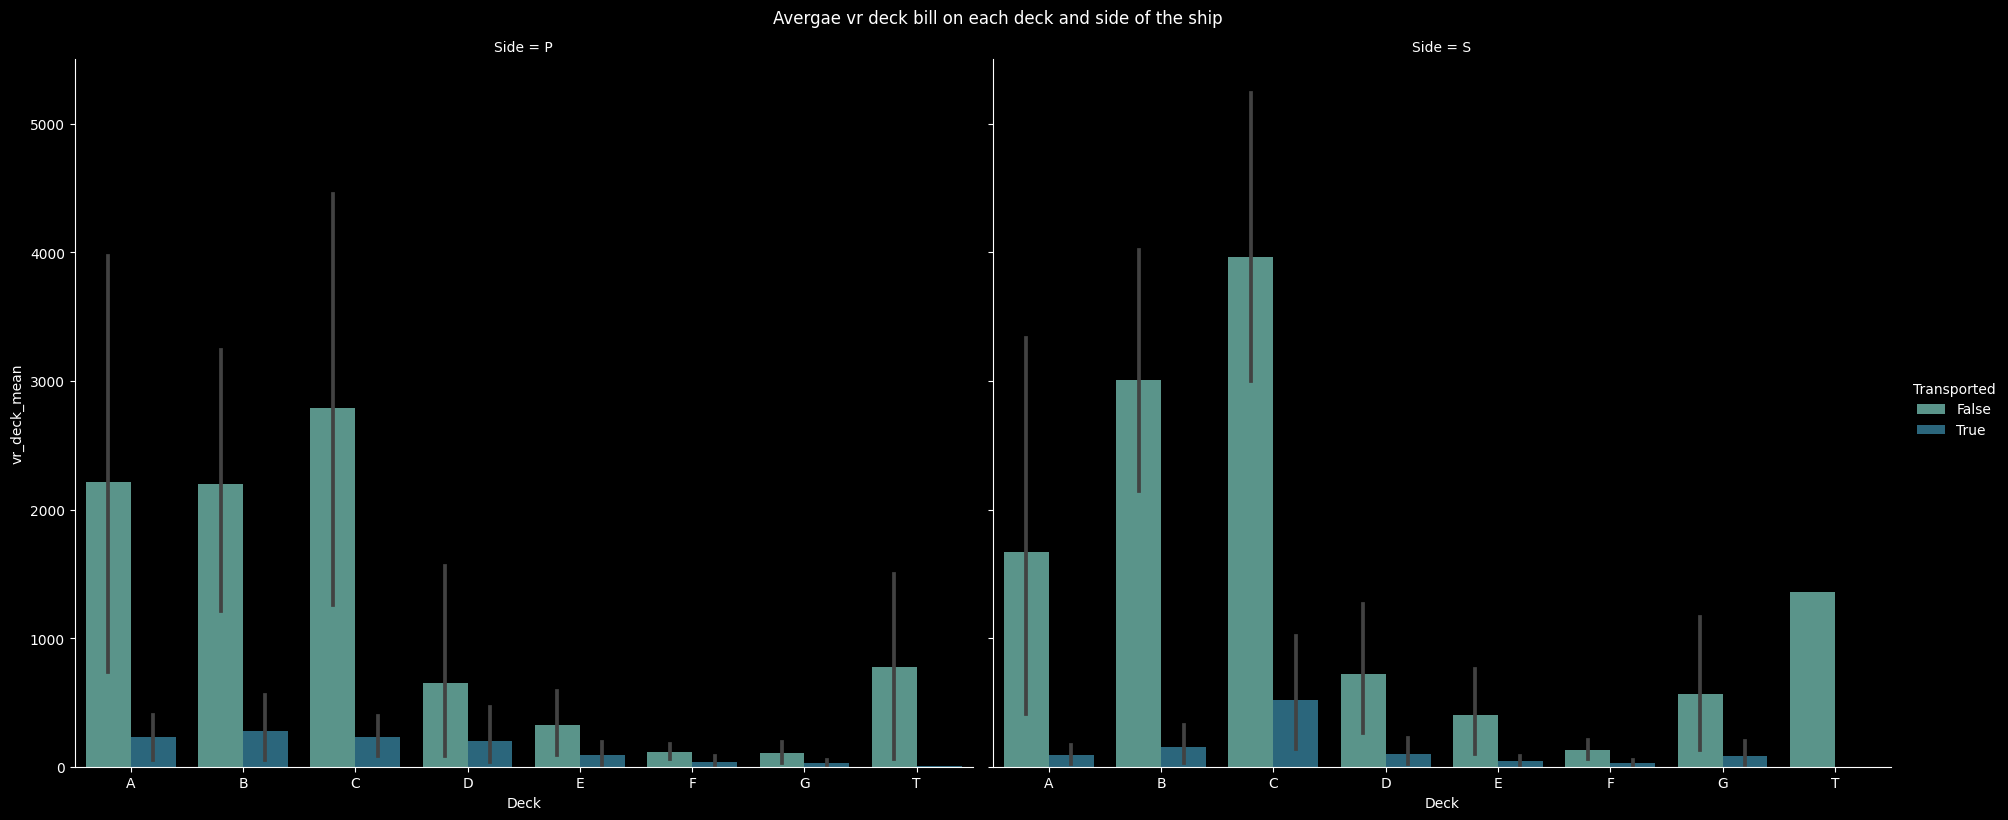

In [39]:
# Plot number of transported passengers and avergae vr deck on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='vr_deck_mean',
    hue='Transported',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Avergae vr deck bill on each deck and side of the ship', y=1.02)

# Show the plot
plt.show()

<Figure size 1000x1000 with 0 Axes>

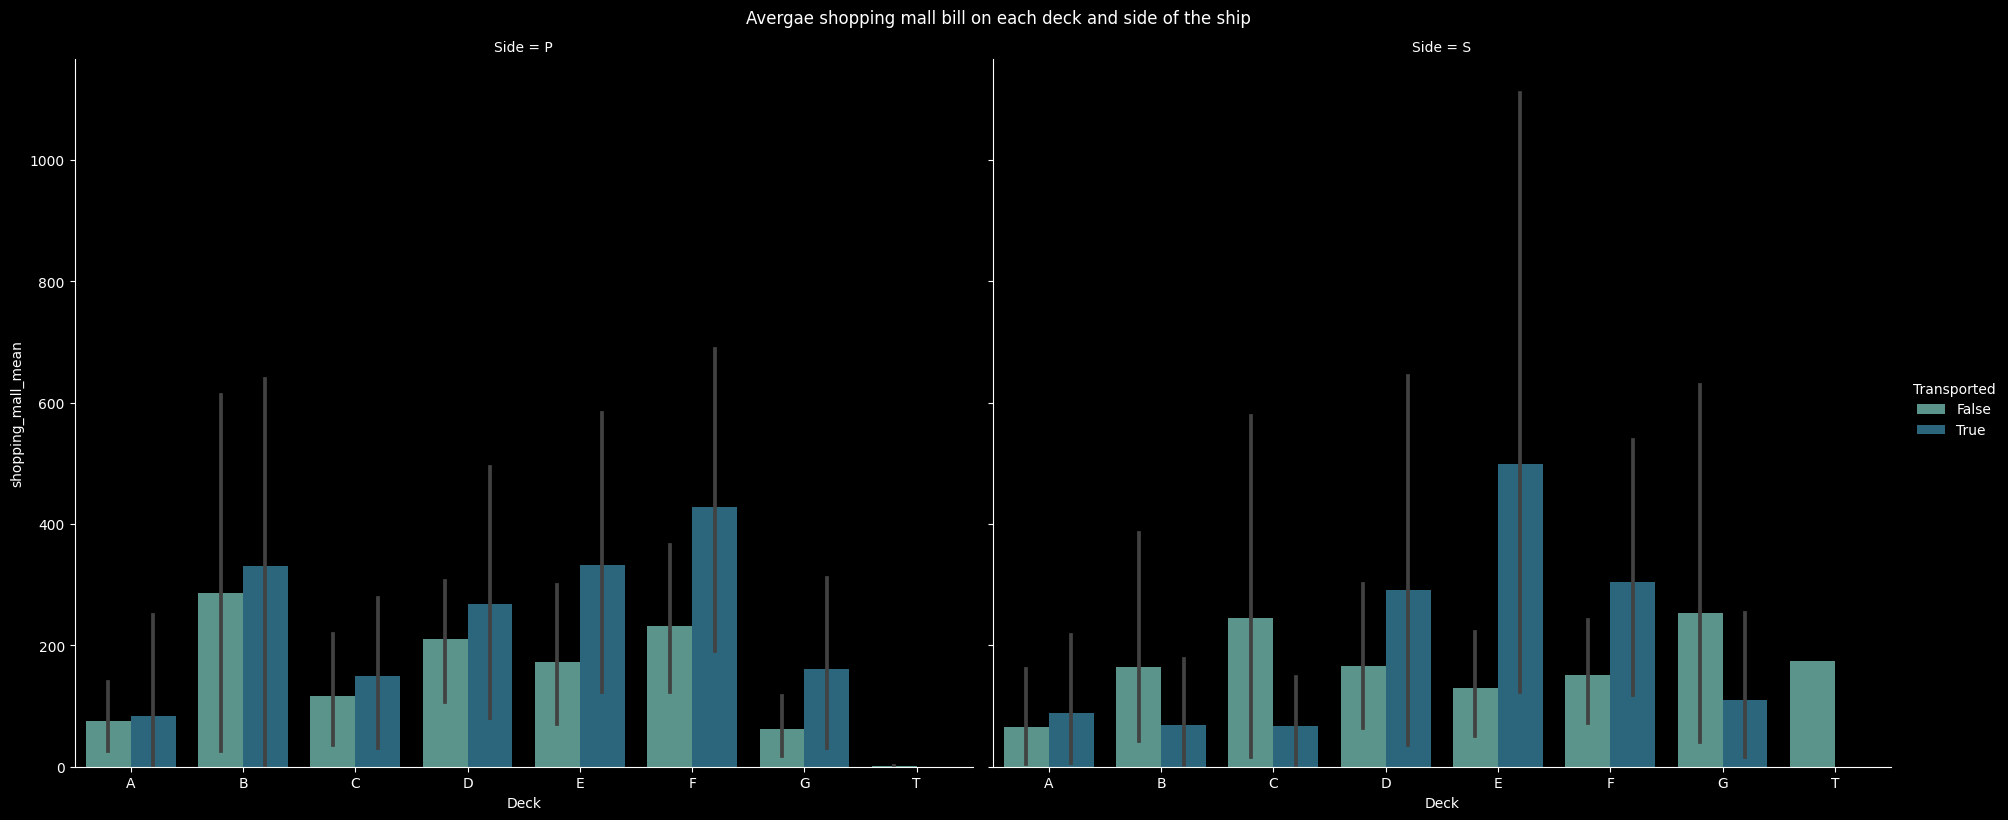

In [40]:
# Plot number of transported passengers and avergae shopping mall on each deck
plt.figure(figsize=(10,10))
plt.style.use("dark_background")
sns.catplot(
    x='Deck',
    y='shopping_mall_mean',
    hue='Transported',
    col='Side',
    data=df_group,
    kind='bar',
    height=8,
    aspect=1.2,
    palette="crest"
)

# Set plot labels and title
plt.xlabel('Deck')
plt.ylabel('passenger_count')
plt.suptitle('Avergae shopping mall bill on each deck and side of the ship', y=1.02)

# Show the plot
plt.show()

### Correlation between columns

To check the correlation between all the columns  in the dataset. The columns has to be transformed to a more suitable format by creating dummy varaibles fro non-numerical columns and converting object columns that contains true or false to a boolean dtypes. Non numerical columns such as Name has to be droped because, every passengers have a unique Name.

CryoSleep                    0.460132
VIP                         -0.056283
RoomService                 -0.243332
FoodCourt                    0.044292
ShoppingMall                 0.007895
Spa                         -0.220081
VRDeck                      -0.206121
Transported                  1.000000
Cabin_num                   -0.044556
HomePlanet_Earth            -0.168845
HomePlanet_Europa            0.176916
HomePlanet_Mars              0.019544
Destination_55 Cancri e      0.108722
Destination_PSO J318.5-22    0.000092
Destination_TRAPPIST-1e     -0.096319
Deck_A                      -0.002623
Deck_B                       0.144733
Deck_C                       0.108193
Deck_D                      -0.034046
Deck_E                      -0.097965
Deck_F                      -0.087753
Deck_G                       0.015822
Deck_T                      -0.014568
Side_P                      -0.101397
Side_S                       0.101397
Name: Transported, dtype: float64


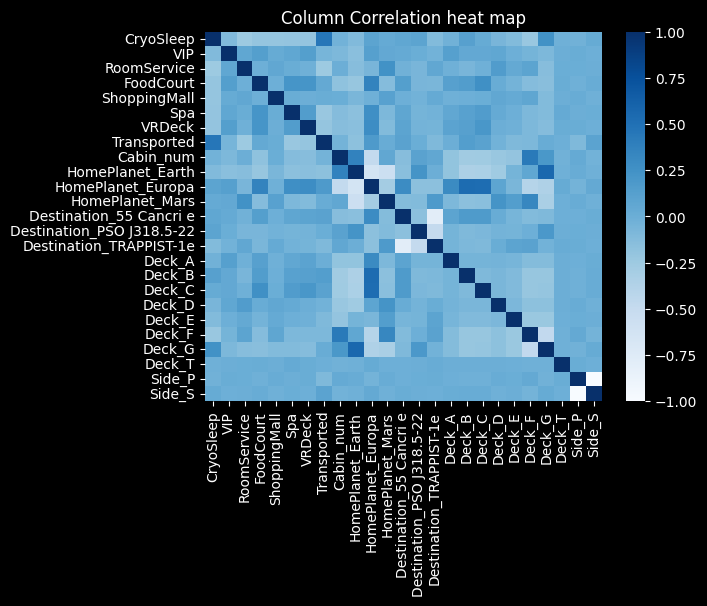

In [41]:
df_droped = df_clean.drop(columns=['PassengerId', 'Name', 'Age'])
object_column = df_droped.select_dtypes(include='object').columns.to_list()
df_cleaned = pd.get_dummies(df_droped, columns=object_column)


corr = df_cleaned.corr()

print(corr['Transported'])
#plt heat map
# Plot the heatmap
heatmap = sns.heatmap(corr, cmap="Blues")

#add title
heatmap.set_title('Column Correlation heat map')

# Show the heatmap
plt.show()


From the correlation matrix it can be observed that the Cryosleep has the highest correlation to the transported class. This means that the Cryosleep status of a passenger has higher contribution to whether the passenger is been transported or not.

## Training the model
After an extensive EDA, we've been able to unveil some insight from the data and how columns correlate to each other. The next task is to train a model that can be used to make accurate prediction. Firstly we will be training 3 base models with different algorithm. The best performing base model will be furthered trained and tuned to output the best result.
The 3 algorithm we will be using are:
1.	Logistic regression:  The logistic regression is a very common algorithm used for binary problem. It uses a sigmoid function f(x) = 1 / (1 + exp(-x)) to model the probability of the target variable with the input x. The model can be implemented in Tensorflow using a single dense layer with a sigmoid activation.
2.	Linear Regression:  The linear regression is also a very common algorithm used for binary classification problem. It uses a linear function y = b0 + b1 * x
•	y represents the dependent variable we want to predict.
•	x represents the independent variable.
•	b0 is the y-intercept, which is the value of y when x is 0.
•	b1 is the slope of the line, representing the change in y for a one-unit increase in x.
This can also be implemented as a Tensorflow model using a single dense layer with a linear activation function.
3.	Deep learning: The Deep learning algorithm is a more advanced algorithm which contains multilayers of fully connected neural network. The input layer receives the input and then passes them to next layers which are called the hidden layers.
Each layers in the hidden layer consist of multiple neurons or units. Each neurons in the hidden layers then applies a weighted sum of the inputs after which an activation function is also applied to give an output. The weighted sum of the input is calculated by weighted sum = (input (1) * weight (1)) + (input (2) * weight (2)) + ... + (input (n)* weight (n)) + bias.
The final layer which is the output layer then receives the outputs from the last layer in the hidden layers. The number of neurons in the final layer depends on the classification task. In a binary classification task a single neuron or unit with sigmoid activation function is used in the output layer. Whereas in a non-binary classification problem the number of neurons in the output layer is equal to the total number of classes and a softmax activation function is used in this case.


In [42]:
# split data into training and validation set
X = df_cleaned.drop('Transported', axis=1)
y = df_cleaned['Transported']

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True)

#scale the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [43]:

def base_model(x_train_scaled, y_train, x_val_scaled, y_val):
  """
  three models will be implemented as base model
  the model with the highest accuracy will be tunned
  """

  epochs = 10
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  loss = 'binary_crossentropy'
  metrics = ['accuracy', 'Precision', 'Recall']
  batch_size = 32


  #model 1 logistic regression
  def logistic():

    def model():
      model = Sequential(layers=[
          layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
          layers.Dense(1, activation='sigmoid')#using sigmoid because its logistic regression
          ],
        name ='logistic_regression')
      return model

    model = model()
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss= loss,
        metrics=metrics
        )

    print('Training Logistic regression model')

    history = model.fit(
        x_train_scaled,
        y_train,
        validation_data=(x_val_scaled, y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    print('Logistic regression model completed')
    return history, model.name, model

  def linear_regression():

    def model():
      model = Sequential(layers=[
          layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
          layers.Dense(1, activation='linear')
          ],
        name ='linear_regression')
      return model

    model = model()
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss= loss,
        metrics=metrics
        )

    print('Training linear regression model')
    history = model.fit(
        x_train_scaled,
        y_train,
        validation_data=(x_val_scaled, y_val),
        epochs=epochs,
        batch_size=batch_size
    )

    print('Linear regression model completed')
    return history, model.name, model

  def deep_learning():

    def model():
      model = Sequential(layers=[
          layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
          layers.Dense(256, activation='relu', name='dense1'),
          layers.Dense(512, activation='relu', name='dense2'),
          layers.Dense(1024, activation='relu', name='dense3'),
          layers.Dense(1, activation='sigmoid', name='output')
      ],
      name='deep_learning'
      )
      return model

    model = model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss= loss,
        metrics=metrics
        )
    print('Training deep learning model')
    history = model.fit(
        x_train_scaled,
        y_train,
        validation_data=(x_val_scaled, y_val),
        epochs=epochs,
        batch_size=batch_size,
        #callbacks=[checkpoint]
    )
    print('Deep learning model completed')
    return history, model.name, model



  def train():

    training_result = {}

    training_metric = [
        'accuracy', 'precision',
        'recall', 'val_accuracy',
        'val_precision', 'val_recall'
          ]

    training_loss = ['loss', 'val_loss']

    models = [logistic(), linear_regression(), deep_learning()]

    for mod in models:
      model_result, model_name, logistic_regression_model = mod
      #visualise training result
      result = pd.DataFrame(model_result.history)
      lineplot(result[training_metric], model_name)
      lineplot(result[training_loss], model_name)
      #max_training accuracy
      max_training_accuracy = (result['accuracy'].max()).round(3)

      training_result[str(model_name)] = max_training_accuracy


    fig = px.bar(x=training_result.keys(),
                 y=training_result.values())

    fig.update_layout(width=800,
                    height=600,
                    title='Base model result',
                    xaxis_title = 'columns',
                    yaxis_title='base model validation accuracy',
                    plot_bgcolor='#000000',
                    paper_bgcolor='#000000',
                    font=dict(color="white"
                    )
    )
    fig.show()


  return train()

In [44]:
base_model(x_train_scaled, y_train, x_val_scaled, y_val)

Training Logistic regression model
Epoch 1/10
204/204 [==============================] - 2s 4ms/step - loss: 0.8783 - accuracy: 0.4651 - precision: 0.4679 - recall: 0.4772 - val_loss: 0.7473 - val_accuracy: 0.5290 - val_precision: 0.5359 - val_recall: 0.5466
Epoch 2/10
204/204 [==============================] - 1s 2ms/step - loss: 0.6899 - accuracy: 0.5897 - precision: 0.5881 - recall: 0.6098 - val_loss: 0.6197 - val_accuracy: 0.6799 - val_precision: 0.6732 - val_recall: 0.7195
Epoch 3/10
204/204 [==============================] - 1s 2ms/step - loss: 0.5937 - accuracy: 0.6958 - precision: 0.6930 - recall: 0.7076 - val_loss: 0.5530 - val_accuracy: 0.7447 - val_precision: 0.7460 - val_recall: 0.7548
Epoch 4/10
204/204 [==============================] - 1s 2ms/step - loss: 0.5429 - accuracy: 0.7305 - precision: 0.7396 - recall: 0.7149 - val_loss: 0.5154 - val_accuracy: 0.7672 - val_precision: 0.7823 - val_recall: 0.7511
Epoch 5/10
204/204 [==============================] - 0s 2ms/step - l

### Base Model Traing

From the Base model training the deep learning model performed best with a validation accuracy of 81%. To further improve the predictive performance of the model we can tune the hyperparameters in order for the training to converge and also add some drop out layers to stop the model for overfitting.

In [45]:
# retrain the deep learning model with an optimal parameter
def model():
    model = Sequential(layers=[
        layers.Input(shape=(x_train_scaled.shape[1]), dtype='float32'),
        layers.Dense(256, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(512, activation='relu', name='dense2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(1024, activation='relu', name='dense3'),
        layers.Dropout(0.3, name='dropout3'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    )
    return model

model = model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'Precision',
        'Recall'
             ]
    )

history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_val_scaled, y_val),
    epochs=60,
    batch_size=32,
    )

#save model
model.save('/content/drive/MyDrive/Spaceship-titanic/model1.h5')

Epoch 1/60
204/204 [==============================] - 6s 22ms/step - loss: 0.5653 - accuracy: 0.7076 - precision: 0.7324 - recall: 0.6581 - val_loss: 0.4427 - val_accuracy: 0.7912 - val_precision: 0.8239 - val_recall: 0.7493
Epoch 2/60
204/204 [==============================] - 3s 16ms/step - loss: 0.4688 - accuracy: 0.7633 - precision: 0.7844 - recall: 0.7290 - val_loss: 0.4171 - val_accuracy: 0.8040 - val_precision: 0.8200 - val_recall: 0.7873
Epoch 3/60
204/204 [==============================] - 3s 16ms/step - loss: 0.4506 - accuracy: 0.7803 - precision: 0.7947 - recall: 0.7583 - val_loss: 0.4054 - val_accuracy: 0.8128 - val_precision: 0.8184 - val_recall: 0.8118
Epoch 4/60
204/204 [==============================] - 4s 21ms/step - loss: 0.4384 - accuracy: 0.7895 - precision: 0.8024 - recall: 0.7705 - val_loss: 0.4013 - val_accuracy: 0.8169 - val_precision: 0.8301 - val_recall: 0.8045
Epoch 5/60
204/204 [==============================] - 4s 18ms/step - loss: 0.4363 - accuracy: 0.7820

In [46]:
result = pd.DataFrame(history.history)
lineplot(result, 'final model')

68/68 [==============================] - 0s 3ms/step


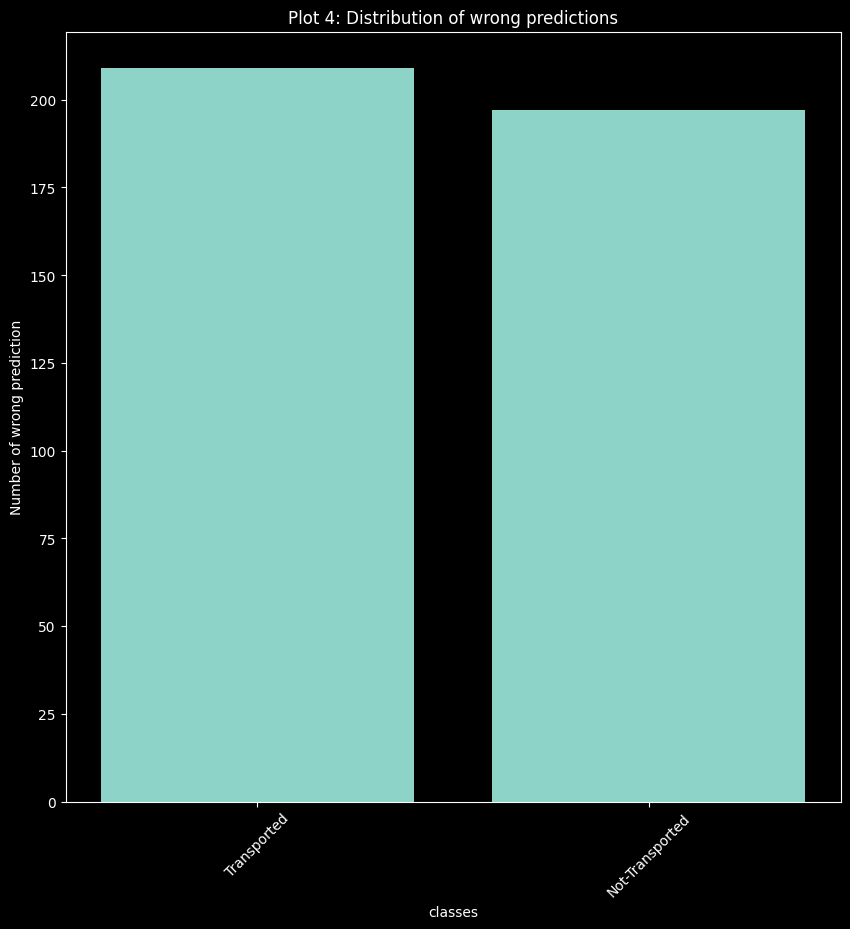

In [47]:
#plot a chart for the wrongly predicted class
class_name = ['Transported', 'Not-Transported']
prediction = model.predict(x_val_scaled)
threshold = 0.5
predicted_label = np.where(prediction >= threshold, 1, 0)


labels = list(y_val)
true_label = np.array(labels)
wrong_prediction = []

#count wrong predictions
for i in range(len(true_label)):
  if predicted_label[i] != true_label[i]:
    wrong_prediction.append(predicted_label[i])

#clean wrong prediction for plotting
df = pd.DataFrame(wrong_prediction, columns=['predicted_label'])
df['predicted_label'].replace([0,1], class_name, inplace=True)
preds_dict = df['predicted_label'].value_counts().to_dict()

#plot barchart of wrong prediction
plt.figure(figsize=(10,10))
plt.title('Plot 4: Distribution of wrong predictions')
plt.bar(preds_dict.keys(), preds_dict.values())
plt.xlabel('classes')
plt.ylabel('Number of wrong prediction')
plt.xticks(rotation=45)
plt.show()

Confusion Matrix:
[[872 197]
 [209 896]]


Text(0.5, 1.0, 'Confussion matrix heatmap')

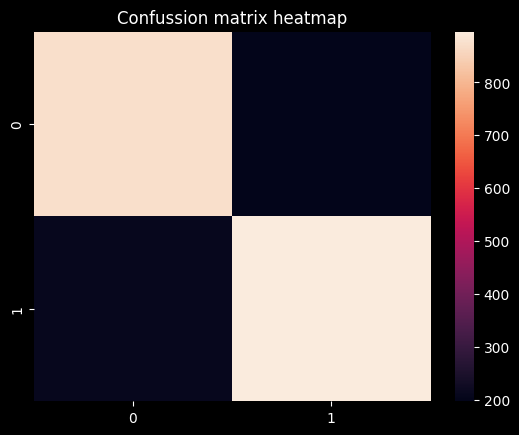

In [48]:

# Calculate the confusion matrix
cm = confusion_matrix(y_val, predicted_label)

print("Confusion Matrix:")
print(cm)

sns.heatmap(cm)
plt.title('Confussion matrix heatmap')

## Results Analysing the final model

The final model was successfully trained to convergence with a max validation accuracy of 82.06%. The predicted class for the validated result will be further explain to better understand what class the model struggles to predict correctly. From the confusion matrix below it can be observed that the distribution false negative and false positive are quite close which means that the model isn't bias in predicting the class each passenger belongs.
From a total 2,174 passengers in the validation dataset:
-	True positive: Number of passengers correctly predicted as positive. In this case 872 out of 2,174 passengers in the validation set.
-	False Positive: Number of passengers that are incorrectly predicted as transported. In this case 197 out of 2,174 passengers in the validation set.
-	True Negative: Number of passengers that are correctly predicted as not transported. In this case 896 out 2,174 passengers in the validation set.
-	False Negative: Number of passengers that are incorrectly predicted as not transported. In this case 209 out of 2,174 passengers in validation set.



## End to End Pipeline
The model can finally be implemented in a end to end machine pipeline that takes in test data or any other titanic spaceship dataset and return predictions using the saved trained model.

In [49]:
## End to End Pipeline
def process_data(csv):
  df = pd.read_csv(csv)

  for col in df.columns:
    if df[str(col)].dtypes == 'object':
      df[str(col)].fillna(df[str(col)].mode()[0], inplace=True)
    elif df[str(col)].dtypes == 'float64':
      df[str(col)].fillna(df[str(col)].mean().round(0), inplace=True)

  df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
  df['Cabin_num'] = df['Cabin_num'].astype(int)
  df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].astype(int)

  #passenger in cryosleep can't buy anything
  df.loc[df['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0


  #passengers in cryosleep can't be vip
  df.loc[df['CryoSleep'] == True, ['VIP']] = False
  bool_column = df.select_dtypes(include='bool').columns

  df[bool_column] = df[bool_column].astype(bool)
  df_clean = df.drop(columns=[ 'PassengerId', 'Name', 'Cabin', 'Age'], axis=1)
  object_column = df_clean.select_dtypes(include='object').columns.to_list()
  df_clean1 = pd.get_dummies(df_clean, columns=object_column)

  x_test_scaled = scaler.transform(df_clean1)

  #load model
  model = models.load_model('/content/drive/MyDrive/Spaceship-titanic/model1.h5')

  #make prediction
  predictions = (model.predict(x_test_scaled) > 0.5).astype(bool)

  submission = pd.DataFrame({"PassengerId": df["PassengerId"],
                           "Transported": np.squeeze(predictions)}).sort_values(by="PassengerId")

  submission.to_csv("submission.csv", index=False)




  return submission.head()


process_data(TEST_PATH)
















134/134 [==============================] - 1s 4ms/step


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


# Conclusion

The predicted result from the trained model was uploaded to kaggle and the score was 81.27%. Putting the model in the top 7% best performing model on kaggle. This shows how advanced and effective the deep learning algorithm is able to make predicton on the dataset. However, the model was unable to predict correct the Transported class of around 19% of the passengers. Additional information or features about each passengers can help increase the accuracy of the model in making prediction. this can be done by fetaure engineering where more features are genertaed from the current datset fatures or gathering more information from the data source. Doing this will increase tehe model accuracy significantly.

## References
-	‘Confusion matrix’ at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html (Accessed: 03 June 2023)
-	‘Spaceship Titanic Dataset’ at https://www.kaggle.com/competitions/spaceship-titanic/data (Accessed: 01 June 2023)
-	‘Tensorflow core API’S overview’ at https://www.tensorflow.org/guide/core (Accessed: 03 June 2023)
